### **DGM – SABR Forward CDF**

* **We solve the forward cumulative distribution function (CDF)**
  under the SABR model using the Deep Galerkin Method (DGM), avoiding the Dirac delta initial condition in the forward PDE by working with the CDF instead.

* **The PDE we solve corresponds to the backward Kolmogorov equation**
  for the cumulative function $u(t, Y, \alpha; Y_T, \alpha_T, \rho, \beta) = \mathbb{P}(Y_T > Y, \alpha_T > \alpha)$, where $Y$ is the forward price and $\alpha$ is the instantaneous volatility.

* **The PDE reads:**

  \begin{align*}
  \frac{\partial u}{\partial t}
  + \frac{1}{2} \alpha^2 Y^{2\beta} \frac{\partial^2 u}{\partial Y^2}
  + \rho \alpha Y^\beta \frac{\partial^2 u}{\partial Y \partial \alpha}
  + \frac{1}{2} \frac{\partial^2 u}{\partial \alpha^2}
  - \frac{1}{2} \frac{\partial u}{\partial \alpha} = 0
  \end{align*}

* **Terminal condition at $t = T$:**

  \begin{align*}
  u(T, Y, \alpha; Y_T, \alpha_T, \rho, \beta) = \mathbf{1}_{\{Y_T > Y,\, \alpha_T > \alpha\}}
  \end{align*}

* **Boundary condition at $Y = 0$:**

  \begin{align*}
  u(t, 0, \alpha; Y_T, \alpha_T, \rho, \beta) = 0
  \end{align*}

  This is justified because the diffusion term $\alpha^2 Y^{2\beta}$ vanishes as $Y \to 0$,
  making it an absorbing boundary. Financially, once the forward price reaches zero,
  the probability of it exceeding any positive $Y_T$ becomes negligible.

* **Network inputs include:**
  $t, Y, \alpha, Y_T, \alpha_T, \rho, \beta$
  (6-dimensional parametric PDE setting)

* **The loss function includes:**

  * PDE residual across the interior domain
  * Boundary loss at $Y = 0$
  * Terminal mismatch between predicted CDF and indicator function at $t = T$

* **After training**, the CDF can be differentiated w\.r.t. $Y_T$ or $\alpha_T$
  to obtain the joint or marginal transition densities.


In [ ]:
import time, pathlib, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.autograd import grad

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# domain limits
T_FINAL = 1.2
Y0_LOW,  Y0_HIGH  = 0.0 , 5.0
A0_LOW,  A0_HIGH  = 0.01, 1.0
YT_LOW,  YT_HIGH  = 0.0 , 5.0
AT_LOW,  AT_HIGH  = 0.01, 2.0
RHO_LOW, RHO_HIGH = -1.0, 0.0
BETA_LOW,BETA_HIGH= 0.5 , 1.0


BATCH_PDE, BATCH_BDRY, BATCH_TERM = 8192, 2048, 4096
STEPS_PER_SAMPLE = 5
SAMPLING_STAGES  = 15000
LR = 1e-3
L_PDE, L_BDRY, L_TERM = 1, 1, 1

# DGM network
class DGMBlock(nn.Module):
    def __init__(self, din, dh):
        super().__init__()
        self.Uz, self.Wz = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ug, self.Wg = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ur, self.Wr = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Uh, self.Wh = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
    def forward(self,x,h):
        z = torch.sigmoid(self.Uz(x)+self.Wz(h))
        g = torch.sigmoid(self.Ug(x)+self.Wg(h))
        r = torch.sigmoid(self.Ur(x)+self.Wr(h))
        h_ = torch.tanh(self.Uh(x)+self.Wh(r*h))
        return (1-g)*h + g*h_
class DGMNet(nn.Module):
    def __init__(self, hidden=64, layers=3):
        super().__init__()
        self.inp   = nn.Linear(1+6, hidden)
        self.blocks= nn.ModuleList([DGMBlock(1+6,hidden) for _ in range(layers)])
        self.out   = nn.Linear(hidden,1)
    def forward(self,t,x):
        z = torch.cat([t,x],1)
        h = torch.tanh(self.inp(z))
        for blk in self.blocks: h = blk(z,h)
        return self.out(h)

model = DGMNet().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)

# sampler
def sampler(n1: int, n2: int, n3: int):
    # PDE interior
    t1  = torch.rand(n1, 1, device=DEVICE) * T_FINAL
    Y1  = torch.rand(n1, 1, device=DEVICE) * (Y0_HIGH - Y0_LOW) + Y0_LOW
    a1  = torch.rand(n1, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT1 = torch.rand(n1, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT1 = torch.rand(n1, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho1  = torch.rand(n1, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta1 = torch.rand(n1, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW

    # boundary Y=0
    t2  = torch.rand(n2, 1, device=DEVICE) * T_FINAL
    Y2  = torch.zeros(n2, 1, device=DEVICE)
    a2  = torch.rand(n2, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT2 = torch.rand(n2, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT2 = torch.rand(n2, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho2  = torch.rand(n2, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta2 = torch.rand(n2, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW

    # terminal t = T
    t3  = T_FINAL * torch.ones(n3, 1, device=DEVICE)
    Y3  = torch.rand(n3, 1, device=DEVICE) * (Y0_HIGH - Y0_LOW) + Y0_LOW
    a3  = torch.rand(n3, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT3 = torch.rand(n3, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT3 = torch.rand(n3, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho3  = torch.rand(n3, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta3 = torch.rand(n3, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW

    return (t1, Y1, a1, YT1, aT1, rho1, beta1,
            t2, Y2, a2, YT2, aT2, rho2, beta2,
            t3, Y3, a3, YT3, aT3, rho3, beta3)

# loss
def loss_fn(mdl,
            t1,Y1,a1,YT1,aT1,rho1,beta1,
            t2,Y2,a2,YT2,aT2,rho2,beta2,
            t3,Y3,a3,YT3,aT3,rho3,beta3):

    x1 = torch.cat([Y1,a1,YT1,aT1,rho1,beta1],1).detach().clone().requires_grad_(True)
    t1r= t1.detach().clone().requires_grad_(True)
    V  = mdl(t1r, x1)

    V_t = grad(V,t1r,torch.ones_like(V),create_graph=True)[0]
    g   = grad(V,x1,torch.ones_like(V),create_graph=True)[0]
    V_Y , V_a = g[:,0:1], g[:,1:2]
    V_YY= grad(V_Y,x1,torch.ones_like(V_Y),create_graph=True)[0][:,0:1]
    V_aa= grad(V_a,x1,torch.ones_like(V_a),create_graph=True)[0][:,1:2]
    V_Ya= grad(V_Y,x1,torch.ones_like(V_Y),create_graph=True)[0][:,1:2]

    f = V_t + 0.5*a1**2 * Y1**(2*beta1) * V_YY \
            + 0.5*V_aa - 0.5*V_a \
            + rho1*a1 * Y1**beta1 * V_Ya
    L1 = (f**2).mean()

    # Y=0 boundary
    V_bdry = mdl(t2, torch.cat([Y2,a2,YT2,aT2,rho2,beta2],1))
    L2 = (V_bdry**2).mean()

    # terminal payoff
    payoff = ((YT3>Y3) & (aT3>a3)).float()
    V_T = mdl(t3, torch.cat([Y3,a3,YT3,aT3,rho3,beta3],1))
    L3 = ((V_T-payoff)**2).mean()
    return L1,L2,L3

LR = 1e-4
opt = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.90)
print("Start training …")
start = time.perf_counter()

for stage in range(1, SAMPLING_STAGES + 1):
    batch = sampler(BATCH_PDE, BATCH_BDRY, BATCH_TERM)

    for _ in range(STEPS_PER_SAMPLE):
        opt.zero_grad()
        L1, L2, L3 = loss_fn(model, *batch)
        loss_tot = L_PDE * L1 + L_BDRY * L2 + L_TERM * L3
        loss_tot.backward()
        opt.step()
    if stage % 500 == 0:
      scheduler.step()

    if stage % 200 == 0:
        cur_lr = scheduler.get_last_lr()[0]
        dt = time.perf_counter() - start
        print(f"stage {stage:05d} | tot {loss_tot.item():.2e} | "
              f"L1 {L1.item():.2e} | L2 {L2.item():.2e} | L3 {L3.item():.2e} | "
              f"lr {cur_lr:.2e} | {dt / stage:.3f}s/ep")


pathlib.Path("Results/SABR_price_noLog").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), "Results/SABR_price_noLog/dgm_sabr_cdf.pth")
print("Weights saved to Results/SABR_price_noLog/dgm_sabr_cdf.pth")



Device: cuda
Start training …
stage 00200 | tot 9.03e-02 | L1 4.24e-03 | L2 5.36e-03 | L3 8.07e-02 | lr 1.00e-04 | 0.321s/ep
stage 00400 | tot 5.51e-02 | L1 4.35e-03 | L2 1.81e-03 | L3 4.90e-02 | lr 1.00e-04 | 0.321s/ep
stage 00600 | tot 4.33e-02 | L1 4.31e-03 | L2 8.96e-04 | L3 3.81e-02 | lr 9.00e-05 | 0.321s/ep
stage 00800 | tot 3.90e-02 | L1 3.62e-03 | L2 7.41e-04 | L3 3.46e-02 | lr 9.00e-05 | 0.321s/ep
stage 01000 | tot 3.64e-02 | L1 3.77e-03 | L2 6.13e-04 | L3 3.20e-02 | lr 8.10e-05 | 0.321s/ep
stage 01200 | tot 3.12e-02 | L1 3.46e-03 | L2 4.18e-04 | L3 2.73e-02 | lr 8.10e-05 | 0.321s/ep
stage 01400 | tot 3.26e-02 | L1 3.47e-03 | L2 3.71e-04 | L3 2.87e-02 | lr 8.10e-05 | 0.321s/ep
stage 01600 | tot 2.83e-02 | L1 3.27e-03 | L2 4.27e-04 | L3 2.46e-02 | lr 7.29e-05 | 0.321s/ep
stage 01800 | tot 2.53e-02 | L1 2.49e-03 | L2 3.40e-04 | L3 2.25e-02 | lr 7.29e-05 | 0.321s/ep
stage 02000 | tot 2.54e-02 | L1 3.04e-03 | L2 3.67e-04 | L3 2.20e-02 | lr 6.56e-05 | 0.321s/ep
stage 02200 | tot 2.

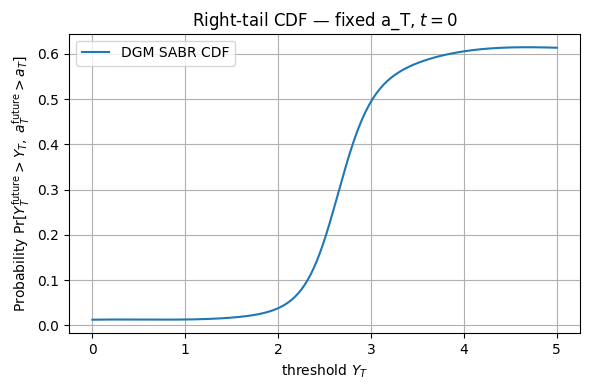

In [ ]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


net = DGMNet().to(DEVICE)
net.load_state_dict(torch.load(
        "Results/SABR_price_noLog/dgm_sabr_cdf.pth",
        map_location=DEVICE))
net.eval()

# slice param
t_now      = 0.9
Y_curr     = 2.5
a_curr     = 0.30
rho_val    = -0.30
beta_val   = 0.70
aT_fixed   = a_curr

YT_grid = np.linspace(0.0, 5.0, 301, dtype=np.float32)
N = len(YT_grid)

t   = torch.full((N,1), t_now,  device=DEVICE)
Y   = torch.full((N,1), Y_curr, device=DEVICE)
a   = torch.full((N,1), a_curr, device=DEVICE)
aT  = torch.full((N,1), aT_fixed, device=DEVICE)
rho = torch.full((N,1), rho_val, device=DEVICE)
beta= torch.full((N,1), beta_val, device=DEVICE)
YT  = torch.from_numpy(YT_grid).view(-1,1).to(DEVICE)

with torch.no_grad():
    x = torch.cat([Y, a, YT, aT, rho, beta], 1)
    cdf_pred = net(t, x).cpu().squeeze().numpy()

plt.figure(figsize=(6,4))
plt.plot(YT_grid, cdf_pred, label="DGM SABR CDF")
plt.xlabel("threshold $Y_T$")
plt.ylabel("Probability $\\Pr[Y_T^{\\text{future}}>Y_T,\\;a_T^{\\text{future}}>a_T]$")
plt.title("Right-tail CDF — fixed a_T, $t=0$")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


Weights loaded ✔


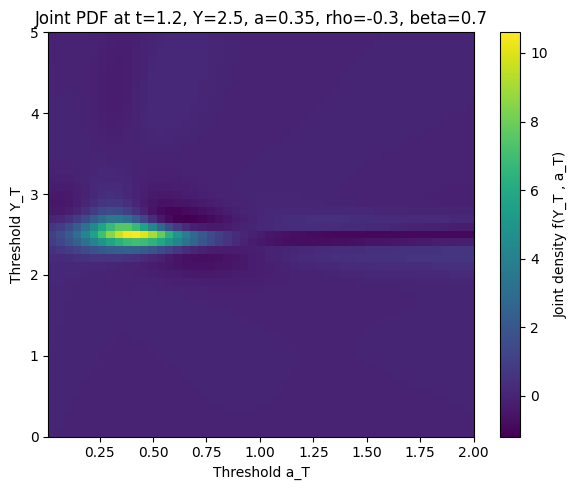

In [ ]:
import torch, matplotlib.pyplot as plt, numpy as np
from torch.autograd import grad
import mpl_toolkits.mplot3d as m3d

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

net = DGMNet().to(DEVICE)
net.load_state_dict(torch.load(
    "Results/SABR_price_noLog/dgm_sabr_cdf.pth", map_location=DEVICE))
net.eval()
print("Weights loaded ✔")

# slice setting
t_now  = 1.2
Y_now  = 2.5
a_now  = 0.35
rho    = -0.3
beta   = 0.7

Y_thresh = np.linspace(0.0, 5.0, 51, dtype=np.float32)
a_thresh = np.linspace(0.01, 2.0, 51, dtype=np.float32)
YY, AA   = np.meshgrid(Y_thresh, a_thresh, indexing="ij")

t_tensor  = torch.full((YY.size,1), t_now,  device=DEVICE)
Y_tensor  = torch.full((YY.size,1), Y_now,  device=DEVICE)
a_tensor  = torch.full((YY.size,1), a_now,  device=DEVICE)
rho_tensor= torch.full((YY.size,1), rho,    device=DEVICE)
beta_tensor=torch.full((YY.size,1), beta,   device=DEVICE)

YT_tensor = torch.from_numpy(YY.ravel()).view(-1,1).to(DEVICE).requires_grad_(True)
aT_tensor = torch.from_numpy(AA.ravel()).view(-1,1).to(DEVICE).requires_grad_(True)

state = torch.cat([Y_tensor, a_tensor,
                   YT_tensor, aT_tensor,
                   rho_tensor, beta_tensor], 1)

with torch.enable_grad():
    cdf_rt = net(t_tensor, state)

grad_YT = -grad(cdf_rt, YT_tensor, torch.ones_like(cdf_rt), create_graph=True)[0]
pdf_joint = -grad(grad_YT, aT_tensor, torch.ones_like(grad_YT))[0] \
              .detach().cpu().view(*YY.shape).numpy()

plt.figure(figsize=(6,5))
plt.imshow(pdf_joint, origin='lower',
           extent=[a_thresh[0], a_thresh[-1], Y_thresh[0], Y_thresh[-1]],
           aspect='auto', cmap='viridis')
plt.colorbar(label="Joint density f(Y_T , a_T)")
plt.xlabel("Threshold a_T")
plt.ylabel("Threshold Y_T")
plt.title(f"Joint PDF at t={t_now}, Y={Y_now}, a={a_now}, rho={rho}, beta={beta}")
plt.tight_layout()
plt.show()


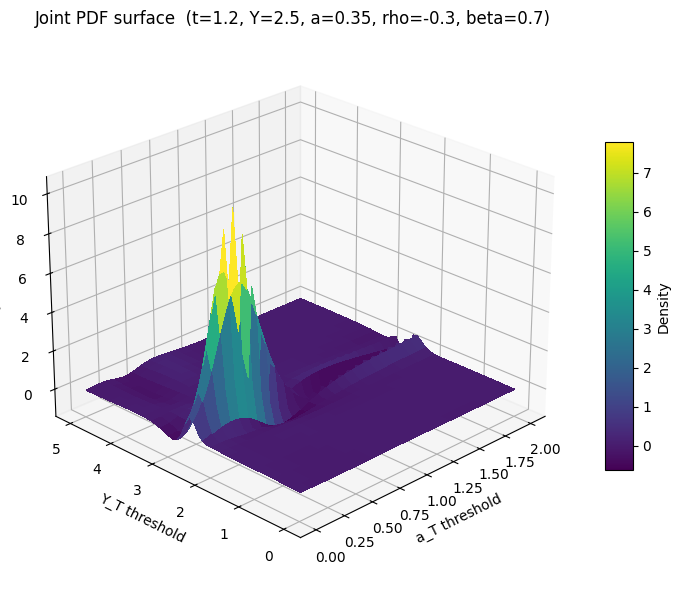

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(AA, YY, pdf_joint,
                       cmap="viridis", linewidth=0, antialiased=False)

ax.set_xlabel("a_T threshold")
ax.set_ylabel("Y_T threshold")
ax.set_zlabel("Density")
ax.set_title(f"Joint PDF surface  (t={t_now}, Y={Y_now}, a={a_now}, "
             f"rho={rho}, beta={beta})")

ax.view_init(elev=25, azim=-135)

fig.colorbar(surf, shrink=0.6, aspect=12, label="Density")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from pathlib import Path
# MC Sample
F0      = 2.5
alpha0  = 0.35
beta    = 0.7
nu      = 1
rho     = -0.3

T, dt   = 1.2, 1/504
n_paths = 50_0000


t_early = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04], dtype=np.float32)
t_main  = np.round(np.linspace(0.05, 1.0, 30), 3)
t_list  = np.unique(np.concatenate([t_early, t_main]))

n_steps = int(T/dt) + 1
times   = np.linspace(0.0, T, n_steps, dtype=np.float32)

Z1 = np.random.normal(size=(n_paths, n_steps-1)).astype(np.float32)
Z2 = np.random.normal(size=(n_paths, n_steps-1)).astype(np.float32)
sqrt_dt = np.sqrt(dt, dtype=np.float32)

dW1 = sqrt_dt * Z1
dW2 = sqrt_dt * (rho*Z1 + np.sqrt(1 - rho**2, dtype=np.float32)*Z2)

F_paths     = np.empty((n_paths, n_steps), dtype=np.float32);  F_paths[:, 0] = F0
alpha_paths = np.empty_like(F_paths);                          alpha_paths[:, 0] = alpha0

F, alpha = F_paths[:, 0].copy(), alpha_paths[:, 0].copy()

for k in range(1, n_steps):
    alpha *= np.exp(nu * dW2[:, k-1] - 0.5 * nu**2 * dt)

    F += alpha * np.power(F, beta, dtype=np.float32) * dW1[:, k-1]

    F_paths[:, k]     = F
    alpha_paths[:, k] = alpha

F_min, F_max, dF = 0, 5.0, 0.04
F_edges = np.arange(F_min, F_max + dF, dF, dtype=np.float32)
F_centers = 0.5 * (F_edges[:-1] + F_edges[1:])

A_min, A_max, dA = 0.0, 0.60, 0.01
A_edges = np.arange(A_min, A_max + dA, dA, dtype=np.float32)
A_centers = 0.5 * (A_edges[:-1] + A_edges[1:])

joint_density = np.empty(
    (len(t_list), len(F_centers), len(A_centers)), dtype=np.float32
)

for i, t in enumerate(t_list):
    idx = np.abs(times - t).argmin()

    F_slice     = F_paths[:, idx]
    alpha_slice = alpha_paths[:, idx]

    counts, _, _ = np.histogram2d(
        F_slice, alpha_slice, bins=[F_edges, A_edges]
    )

    joint_density[i] = counts / (n_paths * dF * dA)

print("joint_density shape:", joint_density.shape)

np.savez_compressed(
    "sabr_joint_density_hist.npz",
    t_list        = t_list.astype(np.float32),
    F_centers     = F_centers,
    A_centers     = A_centers,
    joint_density = joint_density
)



/tmp/ipython-input-132-3297974559.py:44: RuntimeWarning: invalid value encountered in power
  F += alpha * np.power(F, beta, dtype=np.float32) * dW1[:, k-1]


joint_density shape: (37, 125, 60)


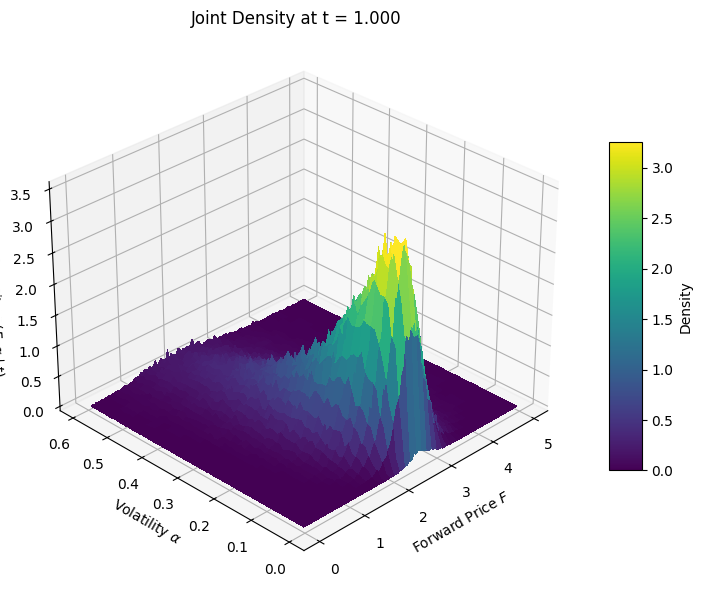

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = np.load("sabr_joint_density_hist.npz")
t_list = data["t_list"]
F_centers = data["F_centers"]
A_centers = data["A_centers"]
joint_density = data["joint_density"]

t_target = 1.0
idx = np.abs(t_list - t_target).argmin()
actual_t = t_list[idx]

Z = joint_density[idx]

F_mesh, A_mesh = np.meshgrid(F_centers, A_centers, indexing='ij')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(F_mesh, A_mesh, Z, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel("Forward Price $F$")
ax.set_ylabel("Volatility $\\alpha$")
ax.set_zlabel("Joint Density $p(F,\\alpha\\mid t)$")
ax.set_title(f"Joint Density at t = {actual_t:.3f}")
ax.view_init(elev=30, azim=-135)
fig.colorbar(surf, shrink=0.6, aspect=10, label="Density")
plt.tight_layout()
plt.show()


In [ ]:
mc = np.load("sabr_joint_density_hist.npz")
F_centers = mc["F_centers"]
A_centers = mc["A_centers"]
t_list = mc["t_list"]
joint_mc = mc["joint_density"]
idx_t = np.abs(t_list - 1.2).argmin()
pdf_mc = joint_mc[idx_t]

idx_Y = np.abs(F_centers - 2.5).argmin()
marginal_alpha_mc = pdf_mc[idx_Y, :]

idx_alpha = np.abs(A_centers - 0.15).argmin()
marginal_Y_mc = pdf_mc[:, idx_alpha]



In [ ]:
idx_Y_dgm = np.abs(Y_thresh - 2.5).argmin()
marginal_alpha_dgm = pdf_joint[idx_Y_dgm, :]

idx_alpha_dgm = np.abs(a_thresh - 0.15).argmin()
marginal_Y_dgm = pdf_joint[:, idx_alpha_dgm]


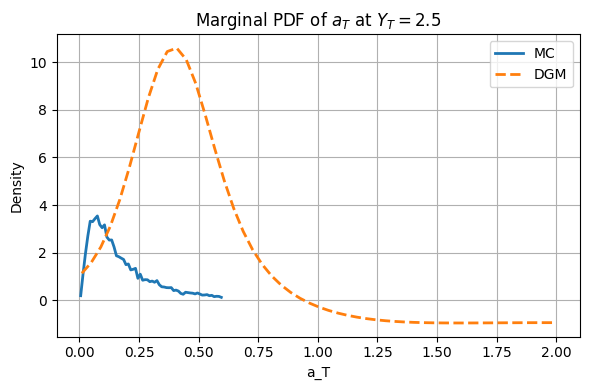

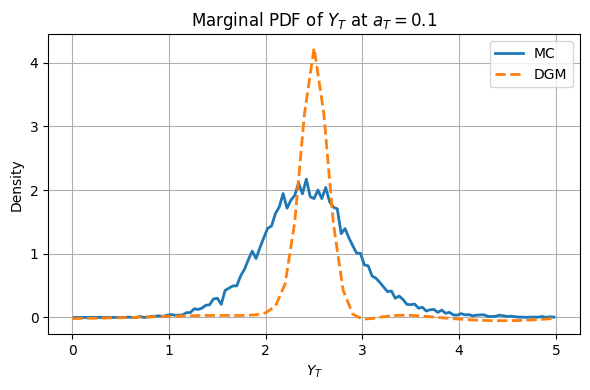

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(A_centers, marginal_alpha_mc, label='MC', lw=2)
plt.plot(a_thresh, marginal_alpha_dgm, label='DGM', lw=2, linestyle='--')
plt.xlabel('a_T')
plt.ylabel('Density')
plt.title('Marginal PDF of $a_T$ at $Y_T = 2.5$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(F_centers, marginal_Y_mc, label='MC', lw=2)
plt.plot(Y_thresh, marginal_Y_dgm, label='DGM', lw=2, linestyle='--')
plt.xlabel('$Y_T$')
plt.ylabel('Density')
plt.title('Marginal PDF of $Y_T$ at $a_T = 0.1$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
